### Imports & declarations

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, load_img, array_to_img, ImageDataGenerator
from keras.models import *
from keras.layers import *

data_path_mini = '../data/raw/kaggle_mini_subsample'
data_path_train = '../data/raw/kaggle/chest_xray/train'
data_path_val = '../data/raw/kaggle/chest_xray/val'

### Mini dataset

In [78]:
BATCH_SIZE = 250
TARGET_SIZE = [128, 128]
image_generator = ImageDataGenerator().flow_from_directory(data_path_mini, batch_size=BATCH_SIZE, target_size=TARGET_SIZE);
images, labels = next(image_generator)
images_scaled = images / 255

display(array_to_img(images[0]))
print(image_generator.class_indices)

Found 500 images belonging to 2 classes.


In [87]:
x = images_scaled.reshape(250,128*128*3)

SHAPE = (x.shape[1],)

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape = SHAPE))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [88]:
history = model.fit(x=x, y=labels, epochs=50)

Epoch 1/120
8/8 [==============================] - 0s 44ms/step - loss: 3.5216 - accuracy: 0.5520
Epoch 2/120
8/8 [==============================] - 0s 44ms/step - loss: 0.7099 - accuracy: 0.5040
Epoch 3/120
8/8 [==============================] - 0s 47ms/step - loss: 0.6486 - accuracy: 0.5840
Epoch 4/120
8/8 [==============================] - 0s 47ms/step - loss: 0.6107 - accuracy: 0.6800
Epoch 5/120
8/8 [==============================] - 0s 49ms/step - loss: 0.6810 - accuracy: 0.6440
Epoch 6/120
8/8 [==============================] - 0s 47ms/step - loss: 0.5777 - accuracy: 0.7680
Epoch 7/120
8/8 [==============================] - 0s 51ms/step - loss: 0.6352 - accuracy: 0.5720
Epoch 8/120
8/8 [==============================] - 0s 48ms/step - loss: 0.4981 - accuracy: 0.7880
Epoch 9/120
8/8 [==============================] - 0s 47ms/step - loss: 0.6032 - accuracy: 0.6960
Epoch 10/120
8/8 [==============================] - 0s 50ms/step - loss: 0.6137 - accuracy: 0.6720
Epoch 11/120
8/8 [=

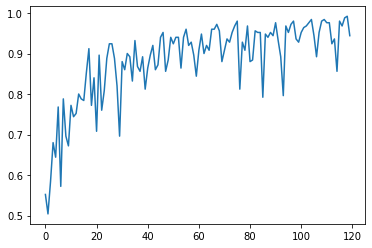

In [94]:
acc = history.history['accuracy']
plt.plot(1+range(len(acc)), acc)

### Full train dataset, no separate validation dataset used

In [104]:
BATCH_SIZE_TRAIN = 1341+3875
BATCH_SIZE_VAL = 8+8
TARGET_SIZE = [128, 128]

generator_train = ImageDataGenerator().flow_from_directory(data_path_train,
                                                          batch_size=BATCH_SIZE_TRAIN,
                                                          target_size=TARGET_SIZE)
generator_val = ImageDataGenerator().flow_from_directory(data_path_val,
                                                        batch_size=BATCH_SIZE_VAL,
                                                        target_size=TARGET_SIZE)

images_train, labels_train = next(generator_train)
images_val, labels_val = next(generator_val)

print(images_train.shape, labels_train.shape)
print(images_val.shape, labels_val.shape)

images_train_scaled = images_train / 256
images_val_scaled = images_val / 256

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
(5216, 128, 128, 3) (5216, 2)
(16, 128, 128, 3) (16, 2)


In [117]:
s = images_train.shape
x = images_train_scaled.reshape(s[0], s[1]*s[2]*s[3])

SHAPE = (x.shape[1],)

print(x.shape, labels_train.shape, SHAPE)

(5216, 49152) (5216, 2) (49152,)


In [120]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape = SHAPE))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [123]:
history = model.fit(x=x, y=labels_train, epochs=100, validation_split=0.2)

Epoch 1/100
131/131 [==============================] - 5s 38ms/step - loss: 0.1252 - accuracy: 0.9492 - val_loss: 0.1238 - val_accuracy: 0.9492
Epoch 2/100
131/131 [==============================] - 5s 36ms/step - loss: 0.1146 - accuracy: 0.9566 - val_loss: 0.1080 - val_accuracy: 0.9569
Epoch 3/100
131/131 [==============================] - 5s 36ms/step - loss: 0.1128 - accuracy: 0.9557 - val_loss: 0.1048 - val_accuracy: 0.9598
Epoch 4/100
131/131 [==============================] - 5s 35ms/step - loss: 0.1144 - accuracy: 0.9549 - val_loss: 0.1755 - val_accuracy: 0.9339
Epoch 5/100
131/131 [==============================] - 5s 36ms/step - loss: 0.1148 - accuracy: 0.9578 - val_loss: 0.1257 - val_accuracy: 0.9483
Epoch 6/100
131/131 [==============================] - 4s 34ms/step - loss: 0.1129 - accuracy: 0.9564 - val_loss: 0.1292 - val_accuracy: 0.9435
Epoch 7/100
131/131 [==============================] - 5s 36ms/step - loss: 0.1095 - accuracy: 0.9595 - val_loss: 0.1466 - val_accuracy:

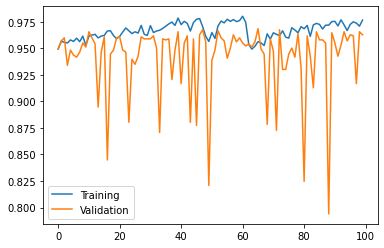

In [132]:
history.history.keys()

acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epoch_ct = range(len(acc_train))

plt.plot(epoch_ct, acc_train, label='Training')
plt.plot(epoch_ct, acc_val, label='Validation')
plt.legend();